# Kriging Neighborhood Analysis (KNA) with Seequent Evo

In [40]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "simple_white"


from evo.notebooks import ServiceManagerWidget, FeedbackWidget
from evo.objects.typed import object_from_uuid, object_from_path
import evo.compute.tasks as tasks

---

## Connect to Evo

In [41]:
manager = await ServiceManagerWidget.with_auth_code(
    client_id="core-compute-tasks-notebooks", 
    base_uri="https://qa-ims.bentley.com",
    discovery_url="https://int-discover.test.api.seequent.com",
    cache_location="./notebook-data",
).login()

ServiceManagerWidget(children=(VBox(children=(HBox(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR…

## Access Geoscience objects

Select the items from your Evo workspace to be used as inputs into Kriging

In [42]:
comps = await object_from_path(manager, "Ag_LMS1 - Ag_ppm Values.json")
grid = await object_from_path(manager, "Kriging Scenarios - 26b90c32-66fb-41e5-987f-3f9a434cda79.json")
variogram = await object_from_path(manager, "Kriging Compute Task/Ag_LMS1: Variogram Model.json")

In [43]:
comps

### Investigate Input Data

Download data into familiar python data structures for analysis and plotting.

#### Point Data


In [44]:
comps

In [45]:
comps_df = await comps.to_dataframe()

In [46]:
pd.DataFrame(comps_df['Ag_ppm Values'].describe())

Ag_ppm Values
count    4791.000000
mean      110.035929
std        76.335792
min         2.475000
25%        49.701200
50%       101.414000
75%       150.356000
max      1302.910000

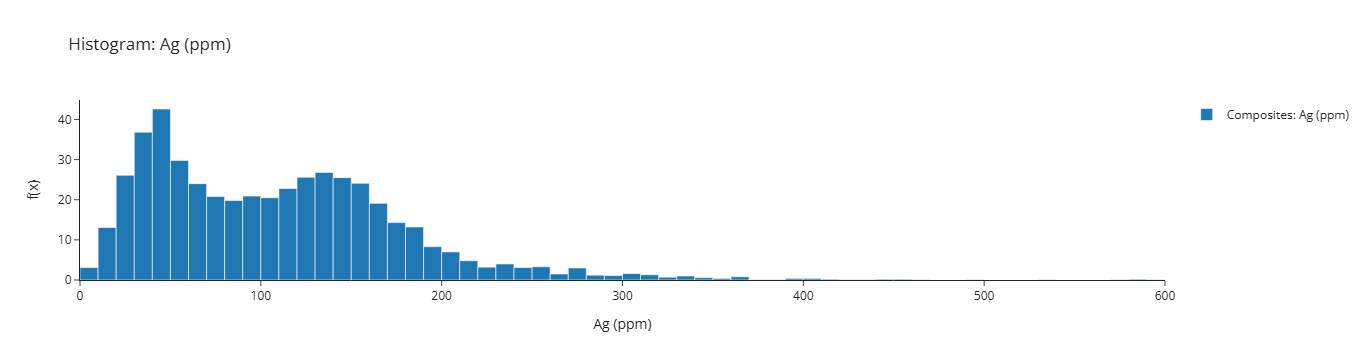

In [47]:
comps_hist = go.Histogram(x=comps_df['Ag_ppm Values'], histnorm='density', name='Composites: Ag (ppm)', showlegend=True)
go.Figure(comps_hist, layout=go.Layout(xaxis_title='Ag (ppm)', xaxis_range=(0,600), yaxis_title='f(x)', title='Histogram: Ag (ppm)'))

#### Variogram Model

In [48]:
variogram

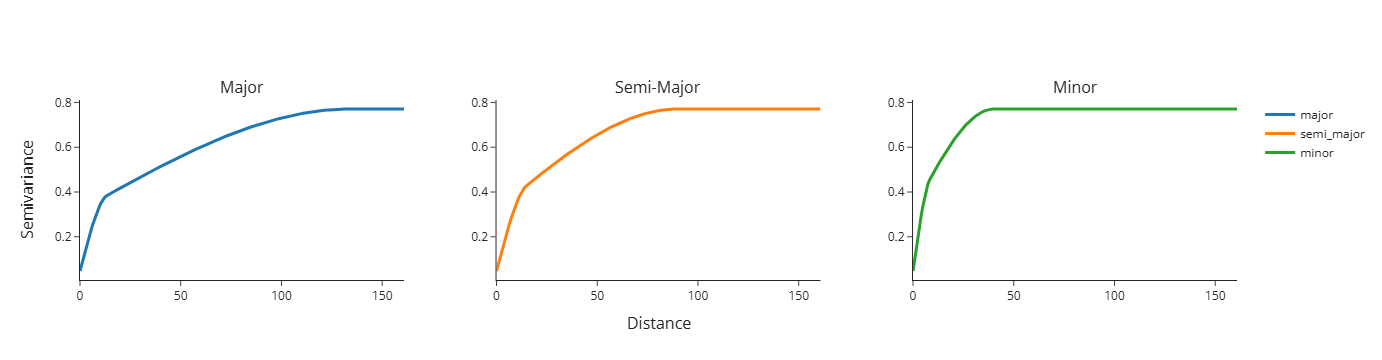

In [49]:
major, semi_major, minor = variogram.get_principal_directions()

fig = make_subplots(
    rows=1, cols=3,
    horizontal_spacing=0.08,
    subplot_titles=("Major", "Semi-Major", "Minor"),
    y_title="Semivariance",
    x_title="Distance"
)

for i, direction in enumerate([major, semi_major, minor], 1):
    fig.add_trace(
        go.Scatter(
            x=direction.distance, y=direction.semivariance/variogram.data_variance,
            mode='lines',
            name=direction.direction,
            line=dict(width=3),
            showlegend=True,
            
        ),
        row=1, col=i
    )
fig

#### Visualize Input Data

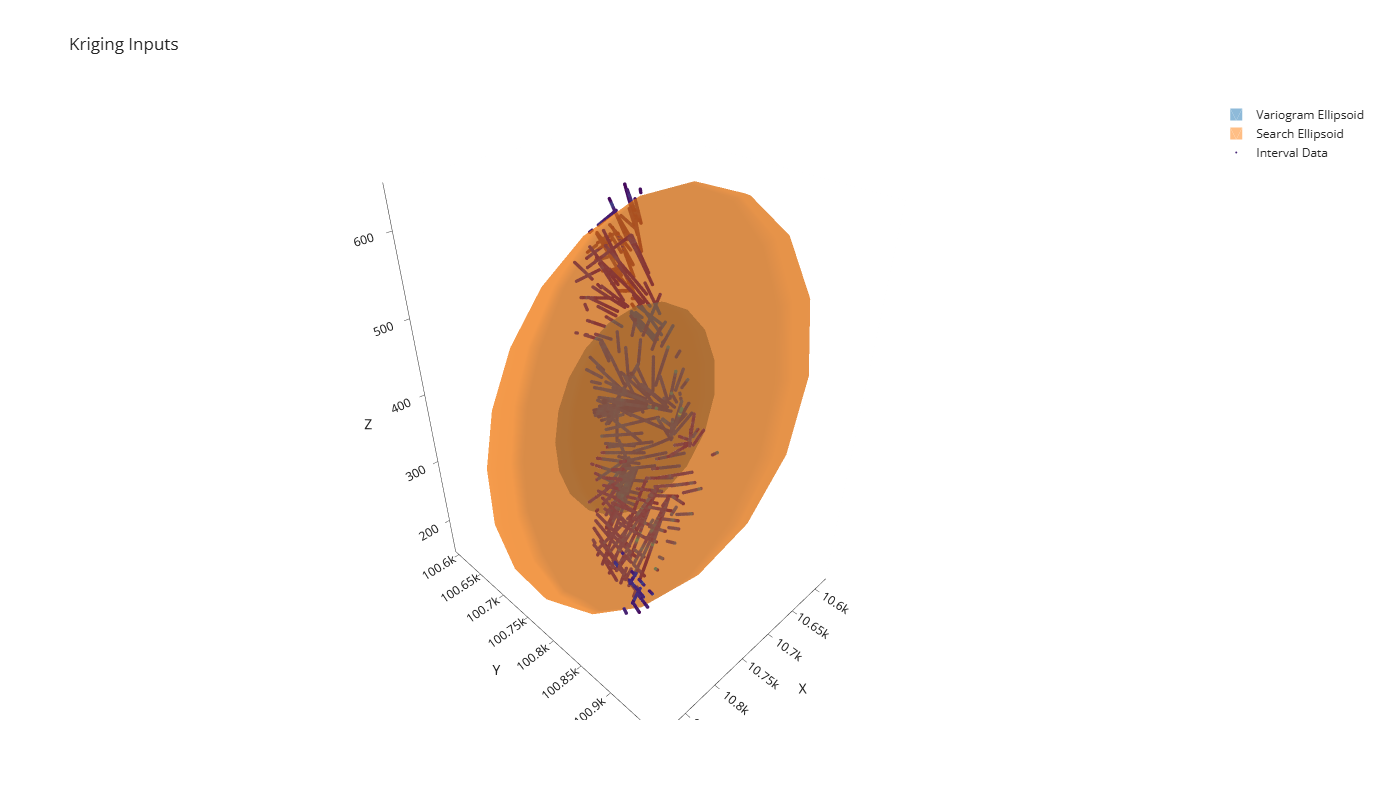

In [50]:
center = (comps_df.x.mean(), comps_df.y.mean(), comps_df.z.mean())
ell = variogram.get_ellipsoid()
srch_ell = ell.scaled(2)
ell_points = ell.surface_points(center=center)
srch_ell_points = srch_ell.surface_points(center=center)

ell_mesh = go.Mesh3d(
    x=ell_points[0],
    y=ell_points[1],
    z=ell_points[2],
    alphahull=1, opacity=0.5, name="Variogram Ellipsoid", showlegend=True)

srch_ell = go.Mesh3d(
    x=srch_ell_points[0],
    y=srch_ell_points[1],
    z=srch_ell_points[2],
    alphahull=1, opacity=0.5, name="Search Ellipsoid", showlegend=True)

scatter = go.Scatter3d(
    x=comps_df['x'],
    y=comps_df['y'],
    z=comps_df['z'],
    mode='markers',
    marker=dict(size=2, color=comps_df['Ag_ppm Values']), name="Interval Data")

go.Figure(data=[ell_mesh, srch_ell, scatter], layout=go.Layout(
    title="Kriging Inputs",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ), showlegend=True,
    width=1200,
    height=800
    
))


#### Establish kriging parameters

In [57]:
kriging_params = tasks.kriging.KrigingParameters(
    source=comps.attributes["Ag_ppm Values"],
    target=grid.attributes['test Ag_ppm'],
    variogram=variogram,
    search=tasks.SearchNeighborhood(
        ellipsoid=ell,
        max_samples=20,
    ),
)

 #### Run the kriging task

Running a compute task by `tasks.run` kicks-off a comupte even on Seequent Evo. This estimation is not running locally but instead, the compute compute is managed by Evo and all inputs are collected from your Evo workspace and results are saved back as Geoscience Objects and/or Blockmodels as determined by the parameters above. 

In [58]:
estimator_job = await tasks.run(manager, kriging_params)

JobError: Error: (422)
Type: https://seequent.com/error-codes/compute-task/unprocessable-entity
Title: Unprocessable entity
Detail: Internal error while running compute task

In [53]:
estimator_job 

NameError: name 'estimator_job' is not defined

In [ ]:
grid = await grid.refresh()
grid_df = await grid.get_data(['Ag_ppm'])
grid_df['Ag_ppm'].describe()
pd.DataFrame([comps_df['Ag_ppm Values'].describe(), grid_df['Ag_ppm'].describe()]).T

In [ ]:
est_hist = go.Histogram(x=comps_df['Ag_ppm Values'], 
                        histnorm='density', name='Estimate: Ag (ppm)', showlegend=True, nbinsx=50)
go.Figure([comps_hist, est_hist], layout=go.Layout(xaxis_title='Ag (ppm)', xaxis_range=(0,600), yaxis_title='f(x)', title='Histogram: Ag (ppm)'))

## Run Multiple Kriging Scenarios in Parallel
---

* Leverage asynchronous API calls to run many kriging scenarios simultaneously
* Orchestrate API calls in familiar python environment thanks the SeequentEvo open source SDK
* Collect results to analyze locally or view and inspect on Evo

### Set up parameters

In [ ]:
max_samples_values =[5, 15, 25, 35, 55]
parameter_sets = []
for max_samples in max_samples_values:
    params = tasks.kriging.KrigingParameters(
        source=comps.attributes["Ag_ppm Values"],
        target=grid.attributes[f"KNA_{max_samples}"],
        variogram=variogram,
        search=tasks.SearchNeighborhood(ellipsoid=ell, max_samples=max_samples),
    )
    parameter_sets.append(params)
print(f"\nCreated {len(parameter_sets)} parameter sets")

### Execute kriging

In [ ]:
results = await tasks.run(manager, parameter_sets)

In [8]:
results

NameError: name 'results' is not defined

### Download Results

In [59]:
grid = await grid.refresh()
grid_cols = [i for i in grid.attributes if i.name.startswith('KNA')]
grid_df = await grid.get_data(columns=[i.name for i in grid_cols])
estimates = grid_df[['KNA_5', 'KNA_15', 'KNA_25', 'KNA_35', 'KNA_55']]

DefaultTypedError: Error: (422) unknown
Type: https://seequent.com/error-codes/block-model-service/unprocessable-entity
Title: Unprocessable Entity
Detail: Query criteria validation failed for block model UUID('d1783d7e-b446-4917-87fb-9044cf1c2e02'): 1 validation error for LiteColumnsValidator
columns
  Value error, Column 'KNA_25' not in column mapping.
Column 'KNA_35' not in column mapping.
Column 'KNA_15' not in column mapping.
Column 'KNA_5' not in column mapping.
Column 'KNA_55' not in column mapping. [type=value_error, input_value=['KNA_25', 'KNA_35', 'KNA_15', 'KNA_5', 'KNA_55'], input_type=list]
    For further information visit https://errors.pydantic.dev/2.12/v/value_error

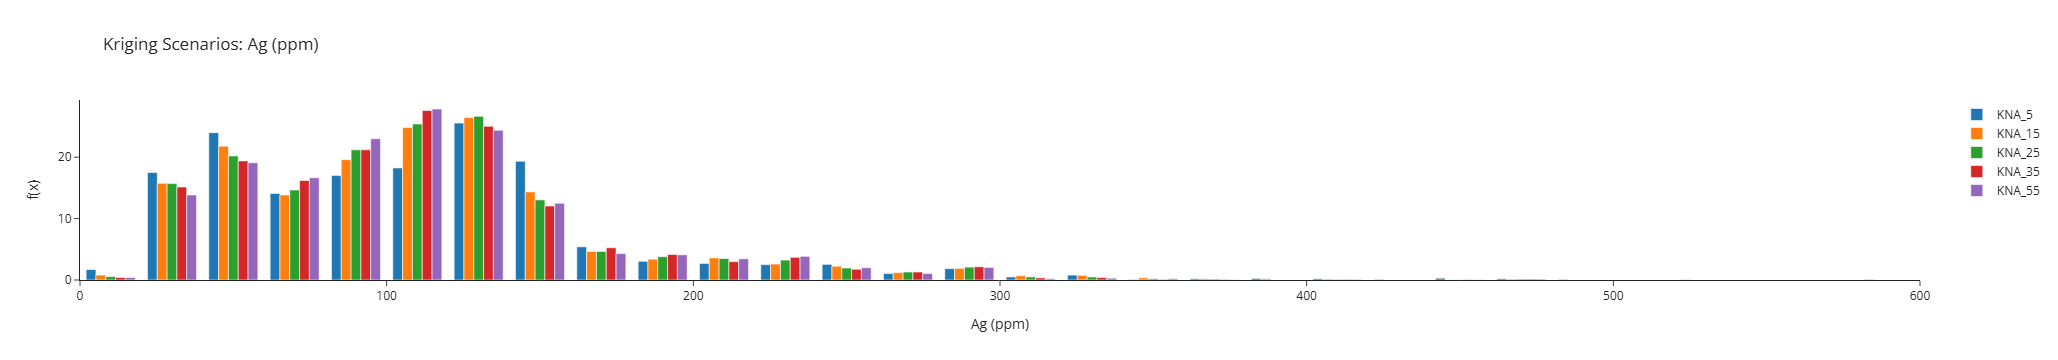

In [74]:
histograms = []
for i in estimates.columns:
    histograms.append(go.Histogram(x=estimates[i], 
                        histnorm='density', name=i, showlegend=True, opacity=1, nbinsx=50))
go.Figure(histograms, layout=go.Layout(xaxis_title='Ag (ppm)', xaxis_range=(0,600), yaxis_title='f(x)', title='Kriging Scenarios: Ag (ppm)'))

In [72]:
estimates.describe()

KNA_5       KNA_15       KNA_25       KNA_35       KNA_55
count  3192.000000  3192.000000  3192.000000  3192.000000  3192.000000
mean    111.617215   111.074042   110.609111   110.247990   110.299475
std      70.982540    63.331597    60.917133    59.788994    58.974244
min       9.187123    13.048721    14.648709    16.415820    11.728001
25%      57.359129    62.451443    65.168071    66.378261    68.055425
50%     106.638244   106.697245   105.454584   105.547731   105.585284
75%     140.905614   136.867462   135.755332   134.817165   134.576128
max     742.603614   465.919000   465.919000   465.919000   465.919000